In [194]:
#import libraries
import sqlite3
import pandas as pd
import numpy as np
import math 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import scipy.stats as stats
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.weightstats import ttest_ind

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [145]:
#Connection Database
con = sqlite3.connect("C:\Personal\Spotahome\Data scientist exercise.db")
df=pd.read_sql_query('SELECT * FROM access_log',con)
con.close()


In [146]:
#Print data
df.head()

,datetime,user_id,variant,city,event_type,revenue
0,2021-08-01 00:00:39,786179591,B,rome,property_view,NaN
1,2021-08-01 00:02:29,790889727,A,rome,property_view,NaN
2,2021-08-01 00:05:58,471152165,B,london,property_favorite_added,NaN
3,2021-08-01 00:06:27,869904661,B,madrid,property_view,NaN
4,2021-08-01 00:06:29,835833313,B,rome,property_favorite_added,NaN


In [147]:
#Descriptive Analysis
df.describe()

,revenue
count,380.000000
mean,248.537161
std,99.668912
min,0.000000
25%,189.897706
50%,222.401133
75%,343.532595
max,444.371649


## 1.-Validate Hypotesis

### 1.1 TEST: A user may be assigned to only one variant. There should be no events for the same user in different variants.

In [148]:
#  check cada usuario pertenece a un único tratamiento
df_aux=df.groupby(['user_id'])['variant'].agg(['count', 'nunique'])
df_aux.describe() #There are user in both groups

,count,nunique
count,1676.000000,1676.000000
mean,9.891408,1.022673
std,6.361274,0.148903
min,1.000000,1.000000
25%,5.000000,1.000000
50%,9.000000,1.000000
75%,13.000000,1.000000
max,43.000000,2.000000


In [149]:
# Calculate num. customers with more than 1 variant
n_customer_gt_1treatment =(df_aux['nunique']>1).sum()
n_customer_gt_1treatment #38 customers in both Groups

38

In [150]:
# ACTION: Drop all register from customer in both variants
df_aux.reset_index()
df_aux=df_aux[df_aux['nunique']==1].drop(columns=['count','nunique'])
df_clean = pd.merge(left=df, right=df_aux, left_on='user_id', right_on='user_id')

In [151]:
df_clean

,datetime,user_id,variant,city,event_type,revenue
0,2021-08-01 00:00:39,786179591,B,rome,property_view,NaN
1,2021-08-03 14:22:33,786179591,B,rome,property_view,NaN
2,2021-08-05 17:17:03,786179591,B,rome,property_view,NaN
3,2021-08-08 17:48:57,786179591,B,rome,property_view,NaN
4,2021-08-14 07:30:09,786179591,B,rome,property_view,NaN
...,...,...,...,...,...,...
15811,2021-08-27 00:58:15,555271151,B,london,property_favorite_added,NaN
15812,2021-08-27 23:51:25,555271151,B,london,property_favorite_added,NaN
15813,2021-08-27 16:01:35,682534992,A,rome,property_view,NaN
15814,2021-08-27 17:09:03,567045519,A,rome,property_favorite_added,NaN


### 1.2 Test: A booking request always has a revenue greater than zero.

In [152]:
#Create a indicator of NaN for event_type=BR
df_clean['br_revenue_is_na']=np.where((df_clean['revenue'].isna()) &(df_clean['event_type']=='booking_request'),1,0)
df_clean['br_revenue_is_na'].sum()# There are 16 BR revenue NaN


16

In [153]:
#Create a indicator of revenue==0 & event_type=BR
df_clean['br_revenue_is_0']=np.where((df_clean['revenue']==0) &(df_clean['event_type']=='booking_request'),1,0)
df_clean['br_revenue_is_0'].sum() # There are 20 BR rev.==0

20

In [154]:
#ACTION: Filter register BR with non >0 revenue
df_clean0 = df_clean[(df_clean['br_revenue_is_0']==0) & (df_clean['br_revenue_is_na']==0)].drop(columns=['br_revenue_is_0','br_revenue_is_na'])
df_clean0.shape[0]


15780

### 1.3 Test: A user can perform only one booking request.

In [155]:
df_filter_br= df_clean0[df_clean0.event_type=='booking_request']
df_filter_br_grouped=df_filter_br.groupby(['user_id'])['revenue'].agg(['count'])
print(df_filter_br_grouped[df_filter_br_grouped['count']>1]) #  the filter dataframe doesn't have users with several booking request 

Empty DataFrame
Columns: [count]
Index: []


## 2.- Calculate Metrics

In [156]:
#Create Target Variable: booking_reserve
df_clean0['booking_request']=np.where((df_clean0.event_type=='booking_request'),1,0)

In [157]:
# Analize if we can include 'city' in the modelling table
df_group_user_city= df_clean0.groupby(['user_id','variant'])['city'].agg(['count', 'nunique'])
df_group_user_city.describe() #each user only search into a unique city

,count,nunique
count,1638.000000,1638.0
mean,9.633700,1.0
std,6.102275,0.0
min,1.000000,1.0
25%,5.000000,1.0
50%,9.000000,1.0
75%,13.000000,1.0
max,35.000000,1.0


In [158]:
# Create a table at user_id level with input and target variables
df_clean0_group= df_clean0.groupby(['user_id','variant','city']).agg({'booking_request':'sum', 
                         'revenue':'mean', 
                         'user_id':'count',
                         'datetime':'max'
                         #'datetime':['min','max']
                         }).rename(columns={'user_id':'visit_num','datetime':'max_datetime'}  )               

df_clean0_group.reset_index(inplace=True)
df_clean0_group.head()

,user_id,variant,city,booking_request,revenue,visit_num,max_datetime
0,100484273,B,madrid,0,NaN,18,2021-08-19 06:01:23
1,101079600,A,madrid,1,203.522684,11,2021-08-27 12:17:24
2,101167498,A,rome,0,NaN,20,2021-08-27 02:30:09
3,101196311,B,madrid,0,NaN,20,2021-08-27 21:48:41
4,101428127,A,madrid,0,NaN,9,2021-08-26 13:10:40


In [159]:
# Conversion rate (CVR) per user: measured as ”unique users that did a BR” / “total unique users”.

In [160]:
#Revenue per user: “total revenue earned” / “total unique users”. Note that we include here users that did not convert.

## 3.- Descriptive Analysis

### 3.1 descriptive analysis "Clean Data" (low level)

In [161]:
#Clean data at web search level
ProfileReport(df_clean0)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


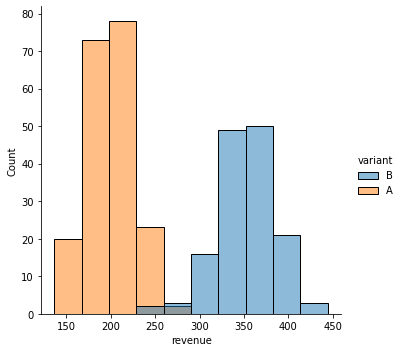

In [162]:
#gráfico revenue*variant
sns.displot(df_clean0, x="revenue", hue="variant")

<AxesSubplot:xlabel='variant', ylabel='count'>

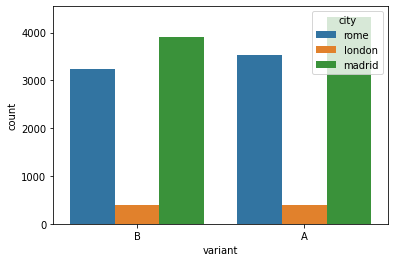

In [163]:
sns.countplot(x='variant',hue='city',data=df_clean0)

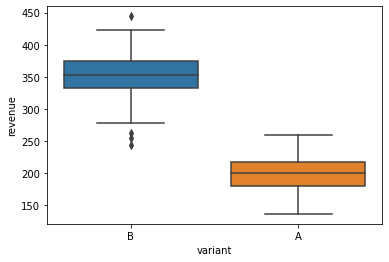

In [164]:
ax = sns.boxplot(x='variant', y='revenue', data=df_clean0)

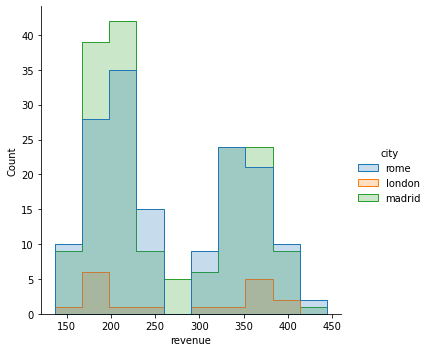

In [165]:
#gráfico revenue*city
sns.displot(df_clean0, x="revenue", hue="city", element="step")

In [166]:
pd.crosstab(df_clean0.city,df_clean0.variant, margins=True)


variant,A,B,All
city,,,
london,386,395,781
madrid,4331,3913,8244
rome,3521,3234,6755
All,8238,7542,15780


In [167]:
pd.crosstab(df_clean0.city,df_clean0.variant, df_clean0.revenue, aggfunc='median', margins=True)

variant,A,B,All
city,,,
london,189.238992,366.293529,265.506598
madrid,202.068261,353.588008,222.987129
rome,200.551353,350.265586,232.054922
All,200.272592,353.520871,227.060692


In [168]:
#crosstab city * variant * booking_reserve
pd.crosstab(df_clean0_group.city,df_clean0_group.variant, df_clean0_group.booking_request, aggfunc='sum', margins=True)
#the results evidence a relation between city & variant, it indicates we have to use city as block factor

variant,A,B,All
city,,,
london,9,9,18
madrid,101,67,168
rome,86,68,154
All,196,144,340


### 3.2 Analysis Modelling Table (at user_id level)

In [169]:
ProfileReport(df_clean0_group)

Render HTML: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]


## 4.- QUESTIONS

### 4.1 ¿What is the uplift or downlift in the treatment group, if there’s any? Is it statistically significant at 95% or 99% level? Indicate the kind of test performed and p-value.

In [170]:
#crosstab  booking_request * Variant
pd.crosstab(df_clean0_group.variant, df_clean0_group.booking_request, margins=True)

booking_request,0,1,All
variant,,,
A,622,196,818
B,676,144,820
All,1298,340,1638


Our classes are unbalanced 

In [171]:
#% Prevalence analysis
count_no_br = len(df_clean0_group[df_clean0_group['booking_request']==0])
count_br = len(df_clean0_group[df_clean0_group['booking_request']==1])
pct_of_br = count_br/(count_no_br+count_br)
print("percentage of customer that made a booking request is", pct_of_br*100)

percentage of customer that made a booking request is 20.757020757020758


The ratio of no-subscription to subscription instances is 20.75%

In [172]:
#crosstab  booking_reserve * Variant (percentages)
pd.crosstab(df_clean0_group.variant, df_clean0_group.booking_request,  normalize='index',margins=True)

booking_request,0,1
variant,,
A,0.760391,0.239609
B,0.824390,0.175610
All,0.792430,0.207570


In [173]:
pd.crosstab(df_clean0.city,df_clean0.variant, margins=True)

variant,A,B,All
city,,,
london,386,395,781
madrid,4331,3913,8244
rome,3521,3234,6755
All,8238,7542,15780


In [177]:
pd.crosstab(df_clean0.city,df_clean0.variant, values=df_clean0.booking_request, aggfunc='sum', margins=True)

variant,A,B,All
city,,,
london,9,9,18
madrid,101,67,168
rome,86,68,154
All,196,144,340


In [179]:
# create dummy variables
cat_vars=['variant', 'city']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df_clean0_group[var], prefix=var)
    df_clean0_group1=df_clean0_group.join(cat_list)
    df_clean0_group= df_clean0_group1
cat_vars=['variant', 'city']
data_vars=df_clean0_group.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [180]:
# Our final data columns will be:
data_final=df_clean0_group[to_keep]
data_final.columns.values

array(['user_id', 'booking_request', 'revenue', 'visit_num',
       'max_datetime', 'variant_A', 'variant_B', 'city_london',
       'city_madrid', 'city_rome'], dtype=object)

In [203]:
#set the independent variables (represented as X) and the dependent variable (represented as y)
#X = data_final.loc[:, data_final.columns != 'booking_request']
#y = data_final.loc[:, data_final.columns == 'booking_request']
#cols=['visit_num', 'variant_A', 'city_madrid', 'city_rome']
cols=[ 'variant_A']
x=data_final[cols]
y=data_final['booking_request']


In [204]:
#Split dataframes in train(75%) & test(25%)
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state=0)

In [205]:
#Fit logistic model 
# A la matriz de predictores se le tiene que añadir una columna de 1s para el intercept del modelo
X_train = sm.add_constant(X_train, prepend=True)
model = sm.Logit(endog=y_train, exog=X_train,)
model = model.fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.502295
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:        booking_request   No. Observations:                 1228
Model:                          Logit   Df Residuals:                     1226
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Feb 2022   Pseudo R-squ.:                0.003811
Time:                        14:35:49   Log-Likelihood:                -616.82
converged:                       True   LL-Null:                       -619.18
Covariance Type:            nonrobust   LLR p-value:                   0.02982
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.5325      0.106    -14.442      0.000      -1.740      -1.325
variant_A      0.3095      0.

In [206]:
#Calculate odds Ratio (Control to treatment)
odds_ratio= math.exp(0.3095)
odds_ratio

1.3627435719748497

RESULTS: The results shows that users who are inside of the control group(variant="A") are 1,36 times more likely to do a booking request than treatment group

In [215]:
#opcional 
# accuracy of test model vs m.a.s 
X_test = sm.add_constant(X_test, prepend=True)
y_pred=model.predict(X_test)
y_pred
classification=np.where(y_pred<pct_of_br,0,1)
accuracy=accuracy_score(
            y_true =    y_test,
            y_pred =    classification,
            normalize=  True
           )
print(f"Test Accuracy: {(100*accuracy)}%")
print

Test Accuracy: 56.34146341463414%


<function print>

### Revenue per user

In [71]:
#perform two-way ANOVA
model = ols('revenue ~ C(variant) + C(city) + C(variant):C(city)', data=df_clean0_group).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(variant),1.935476e+06,1.0,2416.739422,5.562560e-155
C(city),6.865717e+01,2.0,0.042865,9.580464e-01
C(variant):C(city),9.011111e+02,2.0,0.562588,5.702717e-01
Residual,2.674881e+05,334.0,NaN,NaN


In [82]:
# we will use bioinfokit (v1.0.3 or later) for performing tukey HSD test
# check documentation here https://github.com/reneshbedre/bioinfokit
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=df_clean0_group, res_var='revenue', xfac_var='variant', anova_model='booking_reserve ~ C(variant)')
res.tukey_summary

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,A,B,152.888489,152.888489,152.888489,2.557333e+18,0.001


In [ ]:
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
fig = interaction_plot(x=d_melt['Genotype'], trace=d_melt['years'], response=d_melt['value'], 
    colors=['#4c061d','#d17a22', '#b4c292'])
plt.show()